# Machine Learning Zoomcamp Homework Module 6

In [47]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

In [2]:
df = pd.read_csv('housing.csv')

df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [3]:
df = df.fillna(0)
df['median_house_value'] = np.log1p(df['median_house_value'].values)

In [4]:
def split_dataset(data, seed):
    df_full_train, df_test = train_test_split(data, test_size=0.2, random_state = seed)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state = seed)
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    return df_full_train, df_train, df_val, df_test

In [5]:
df_full_train, df_train, df_val, df_test = split_dataset(df, 1)

In [6]:
y_train = df_train['median_house_value']
y_test = df_test['median_house_value']
y_val = df_val['median_house_value']


del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']

In [7]:
train_dicts = df_train.to_dict(orient = 'records')
dicts_full_train = df_full_train.to_dict(orient = 'records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`


In [8]:
dt = DecisionTreeRegressor(max_depth=1)

dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



**Answer:** ocean_proximity

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=1, random_state=1)

In [22]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = rf.predict(X_val)

In [12]:
from sklearn.metrics import mean_squared_error

In [25]:
import numpy as np
rsme = np.sqrt(mean_squared_error(y_val, y_pred))
rsme

0.24459962783255346

**Answer:** 0.245

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- 160

In [31]:
scores = []

for n in range (10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=12)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict(X_val)
    rsme = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n,rsme))

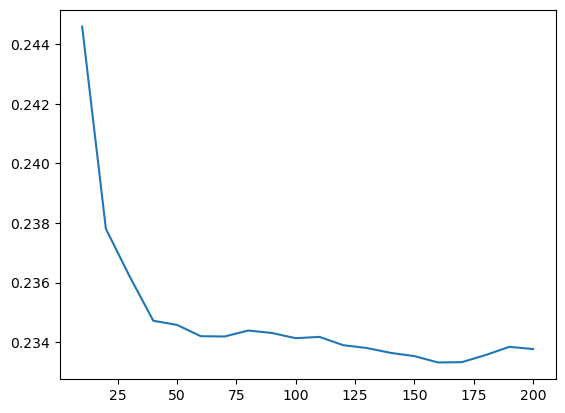

In [33]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rsme'])
plt.plot(df_scores.n_estimators, df_scores.rsme)

**Answer:** 50

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [34]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range (10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, 
                                    random_state=1,
                                    max_depth=d, n_jobs=12)
        rf.fit(X_train,y_train)
        
        y_pred = rf.predict(X_val)
        rsme = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d, n,rsme))
        
columns = ['max_depth','n_estimators', 'rsme']
df_scores = pd.DataFrame(scores, columns=columns)

In [35]:
df_scores_pivot = df_scores.pivot(index = 'n_estimators', 
                                  
                                  columns = ['max_depth'], values = ['rsme'])
df_scores_pivot

rsme                              
max_depth           10        15        20        25
n_estimators                                        
10            0.250510  0.245529  0.244209  0.243913
20            0.247411  0.238977  0.238423  0.238122
30            0.246377  0.236949  0.236458  0.236305
40            0.245170  0.235712  0.234863  0.234386
50            0.245689  0.235926  0.234684  0.234453
60            0.245533  0.235524  0.234583  0.234131
70            0.245495  0.235379  0.234535  0.234015
80            0.245653  0.235656  0.234817  0.234246
90            0.245530  0.235418  0.234546  0.234161
100           0.245414  0.235242  0.234480  0.233991
110           0.245293  0.235148  0.234413  0.234011
120           0.245017  0.234795  0.234348  0.233797
130           0.244775  0.234701  0.234092  0.233766
140           0.244600  0.234620  0.233899  0.233573
150           0.244596  0.234505  0.233734  0.233472
160           0.244486  0.234290  0.233614  0.233410
170           0.244428  0.234216  0.233598  0.233400
180           0.244527  0.234479  0.233745  0.233590
190           0.244722  0.234682  0.233992  0.233829
200           0.244752  0.234574  0.233881  0.233688

**Answer:** 25

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [37]:
dt = RandomForestRegressor(n_estimators=10, max_depth=20,
                           random_state=1, n_jobs=-1)
dt.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [45]:
df_feature_importance = pd.DataFrame({'feature':list(dv.get_feature_names_out()),
                  'Importance':list(dt.feature_importances_)})
df_feature_importance.sort_values('Importance', ascending=False)

,feature,Importance
4,median_income,0.335486
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
2,latitude,0.102665
3,longitude,0.085853
1,housing_median_age,0.030063
7,population,0.028115
9,total_rooms,0.021062
8,total_bedrooms,0.015434
0,households,0.015043


**Answer:** median_income

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [54]:
features = list(dv.get_feature_names_out())
features[5] = 'ocean_proximity=less1H OCEAN'

In [55]:
dtrain = xgb.DMatrix(X_train,label=y_train, feature_names= features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names= features)

C:\Users\davidamo\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [65]:

watchlist = [(dtrain,"train"),(dval, "validation")]
watchlist

[(<xgboost.core.DMatrix at 0x1d5d9e3e250>, 'train'),
 (<xgboost.core.DMatrix at 0x1d5d8d0ce10>, 'validation')]

In [88]:
scores = {}

In [91]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  evals=watchlist,
                  num_boost_round=100)

In [92]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [93]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        
    columns = ['num_iter', 'train_auc', 'val_rsme']
    df_results = pd.DataFrame(results, columns = columns)
    return df_results

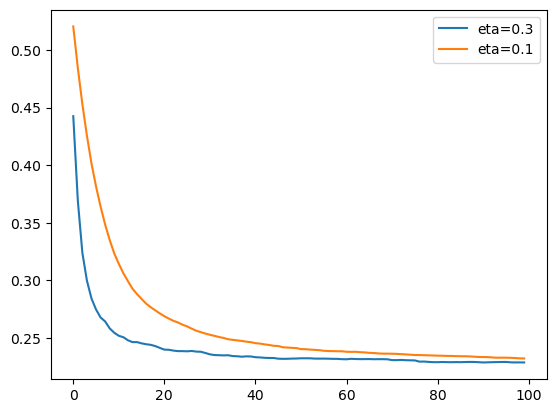

In [94]:
etas = ['eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter,df_score.val_rsme, label = eta)
plt.legend()

**Answer:** eta=0.3